# A2C (Advantage Actor-Critic)
### Solving `Pendulum-v1` Problem
> Deep RL course - Fall 2024 - Sharif University of Technology - Workshop session <br>
> Author: M Narimani - December 15th, 2024

In [1]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import tensorflow_probability as tfp
import gym
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
import threading
from queue import Queue

In [2]:
# Environment setup
env = gym.make('Pendulum-v1')
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.shape[0]
action_bound = [env.action_space.low, env.action_space.high]

# Hyperparameters
num_workers = 4 # cpu_count()
num_episodes = 3000
num_timesteps = 200
gamma = 0.90
beta = 0.01  # Entropy coefficient

print("TensorFlow %s" % tf.__version__)
print("tfp %s" % tfp.__version__)
print("gym %s" % gym.__version__)
print("numpy %s" % np.__version__)

TensorFlow 2.17.0
tfp 0.24.0
gym 0.26.0
numpy 1.26.4


## A2C algorithm

<center>
<img src="a2c_dong.png" alt="A3C" width=500/>
</center>

In [3]:
class ActorNetwork(tf.keras.Model):
    def __init__(self):
        super(ActorNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(400, activation='relu')
        self.mean = tf.keras.layers.Dense(action_shape, activation='tanh')
        self.variance = tf.keras.layers.Dense(action_shape, activation='softplus')
        
    def call(self, state):
        x = self.dense1(state)
        mean = self.mean(x)
        variance = self.variance(x)
        return mean, variance
        
    def build_networks(self):
        dummy_state = tf.zeros([1, state_shape])
        self(dummy_state)

class CriticNetwork(tf.keras.Model):
    def __init__(self):
        super(CriticNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(400, activation='relu')
        self.value = tf.keras.layers.Dense(1)
        
    def call(self, state):
        x = self.dense1(state)
        value = self.value(x)
        return value
        
    def build_networks(self):
        dummy_state = tf.zeros([1, state_shape])
        self(dummy_state)

In [4]:
class GlobalAgent:
    def __init__(self):
        self.actor = ActorNetwork()
        self.critic = CriticNetwork()
        
        self.actor.build_networks()
        self.critic.build_networks()
        
        self.actor_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        self.critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
    
    def update(self, all_gradients):
        """Perform synchronous update with accumulated gradients from all workers"""
        # Unzip gradients
        actor_gradients_list = [g[0] for g in all_gradients]
        critic_gradients_list = [g[1] for g in all_gradients]
        
        # Average gradients across all workers
        avg_actor_grads = [
            tf.reduce_mean([grads[i] for grads in actor_gradients_list], axis=0)
            for i in range(len(actor_gradients_list[0]))
        ]
        avg_critic_grads = [
            tf.reduce_mean([grads[i] for grads in critic_gradients_list], axis=0)
            for i in range(len(critic_gradients_list[0]))
        ]
        
        # Apply averaged gradients
        self.actor_optimizer.apply_gradients(
            zip(avg_actor_grads, self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(
            zip(avg_critic_grads, self.critic.trainable_variables))

In [5]:
class Worker:
    def __init__(self, name, global_agent, gradient_queue):
        self.env = gym.make('Pendulum-v1')
        self.name = name
        self.global_agent = global_agent
        self.gradient_queue = gradient_queue
        
        # Local networks
        self.actor = ActorNetwork()
        self.critic = CriticNetwork()
        
        self.actor.build_networks()
        self.critic.build_networks()
        
        self.sync_with_global()
    
    def sync_with_global(self):
        """Synchronize local networks with global networks"""
        self.actor.set_weights(self.global_agent.actor.get_weights())
        self.critic.set_weights(self.global_agent.critic.get_weights())
    
    def select_action(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        mean, variance = self.actor(state)
        mean = mean * action_bound[1]
        variance = variance + 1e-4
        
        normal_dist = tf.random.normal(shape=mean.shape)
        action = mean + tf.sqrt(variance) * normal_dist
        action = tf.clip_by_value(action, action_bound[0], action_bound[1])
        
        return action[0]
    
    def compute_gradients(self, states, actions, target_values):
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        target_values = tf.convert_to_tensor(target_values, dtype=tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            # Actor forward pass
            mean, variance = self.actor(states)
            mean = mean * action_bound[1]
            variance = variance + 1e-4
            
            # Create normal distribution
            dist = tfp.distributions.Normal(mean, tf.sqrt(variance))
            log_prob = tf.reduce_sum(dist.log_prob(actions), axis=1, keepdims=True)
            entropy = tf.reduce_sum(dist.entropy(), axis=1, keepdims=True)
            
            # Critic forward pass
            values = self.critic(states)
            td_error = target_values - values
            
            # Define losses
            actor_loss = -tf.reduce_mean(log_prob * tf.stop_gradient(td_error) + beta * entropy)
            critic_loss = tf.reduce_mean(tf.square(td_error))
        
        # Compute gradients
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        
        # Clip gradients
        actor_grads = [tf.clip_by_norm(g, 40) for grad in actor_grads if grad is not None]
        critic_grads = [tf.clip_by_norm(g, 40) for grad in critic_grads if grad is not None]
        
        return actor_grads, critic_grads
        
    
    def work(self, coordinator):
        global global_rewards, global_episodes
        episode = 0
        
        while episode < num_episodes and not coordinator.should_stop():
            state, _ = self.env.reset()
            batch_states, batch_actions, batch_rewards = [], [], []
            episode_reward = 0
            
            for t in range(num_timesteps):
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                
                done = True if t == num_timesteps - 1 else False
                episode_reward += reward
                
                batch_states.append(state)
                batch_actions.append(action)
                batch_rewards.append(reward)
                
                if done:
                    if done:
                        target = 0
                    else:
                        target = self.critic(tf.convert_to_tensor([next_state], dtype=tf.float32))
                        target = target.numpy()[0, 0]
                    
                    # Target values
                    batch_target_value = []
                    for reward in batch_rewards[::-1]:
                        target = reward + gamma * target
                        batch_target_value.append(target)
                    batch_target_value.reverse()
                    
                    # Compute gradients and add to queue
                    gradients = self.compute_gradients(
                        np.vstack(batch_states),
                        np.vstack(batch_actions),
                        np.vstack(batch_target_value)
                    )
                    self.gradient_queue.put(gradients)
                    
                    # Update episode stats
                    global_rewards.append(episode_reward)
                    episode += 1
                    
                    if (episode+1) % 10 == 0:
                        print(
                            self.name,
                            "Epispde:", episode+1,
                            "| Reward: %i" % global_rewards[-1]
                            )
                    break
                
                state = next_state

## Main

In [6]:
# Initialize global agent and gradient queue
global_agent = GlobalAgent()
gradient_queue = Queue()
global_rewards = []
global_episodes = 0

# Create coordinator for managing workers
coordinator = tf.train.Coordinator()

# Initialize workers
workers = [Worker(f'W_{i}', global_agent, gradient_queue) 
          for i in range(num_workers)]

# Create worker threads
worker_threads = []
for worker in workers:
    thread = threading.Thread(target=worker.work, args=(coordinator,))
    thread.start()
    worker_threads.append(thread)

try:
    while global_episodes < num_episodes:
        # Wait for all workers to submit their gradients
        all_gradients = []
        for _ in range(num_workers):
            gradients = gradient_queue.get()
            all_gradients.append(gradients)
        
        # Perform synchronous update
        global_agent.update(all_gradients)
        
        # Synchronize all workers with updated global networks
        for worker in workers:
            worker.sync_with_global()
        
        global_episodes += num_workers
        
except Exception as e:
    print(f"Training error: {e}")
    coordinator.request_stop()

coordinator.request_stop()
coordinator.join(worker_threads)

C:\Users\Victus\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


W_3 Epispde: 10 | Reward: -1756 | Actor loss: -84.18582 | Critic loss: 5113.678
W_1 Epispde: 10 | Reward: -1721 | Actor loss: -81.78818 | Critic loss: 4543.832
W_2 Epispde: 10 | Reward: -1710 | Actor loss: -87.148674 | Critic loss: 4570.506
W_0 Epispde: 10 | Reward: -1704 | Actor loss: -81.950195 | Critic loss: 4442.255
W_3 Epispde: 20 | Reward: -1608 | Actor loss: -34.31138 | Critic loss: 965.96265
W_1 Epispde: 20 | Reward: -1488 | Actor loss: -31.971909 | Critic loss: 912.16486
W_2 Epispde: 20 | Reward: -1674 | Actor loss: -37.064632 | Critic loss: 1002.9778
W_0 Epispde: 20 | Reward: -1631 | Actor loss: -35.9813 | Critic loss: 934.2342
W_3 Epispde: 30 | Reward: -1481 | Actor loss: 0.23926428 | Critic loss: 335.4389
W_1 Epispde: 30 | Reward: -1560 | Actor loss: 1.0399741 | Critic loss: 284.7915
W_0 Epispde: 30 | Reward: -1633 | Actor loss: 0.31614223 | Critic loss: 218.29192
W_2 Epispde: 30 | Reward: -1518 | Actor loss: 2.0356896 | Critic loss: 341.34406
W_3 Epispde: 40 | Reward: -159

# Results
## Learning curves

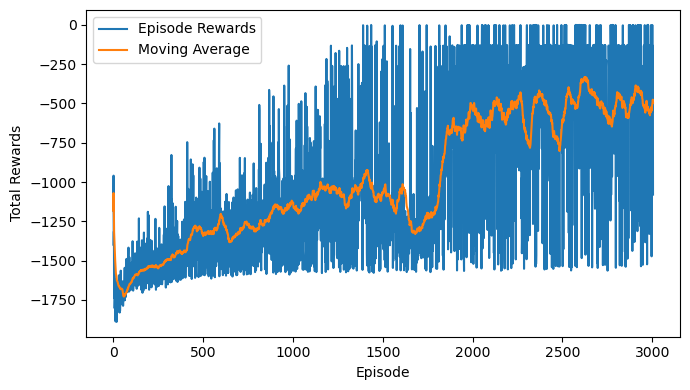

In [7]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    totalrewards = np.array(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-50):(t+1)].mean()
    
    plt.figure(figsize=(7, 4))
    plt.plot(totalrewards, label='Episode Rewards')
    plt.plot(running_avg, label='Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Total Rewards')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_running_avg(global_rewards)

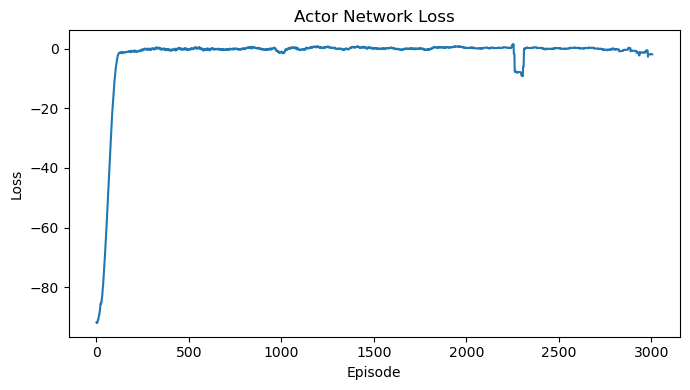

In [8]:
# TODO

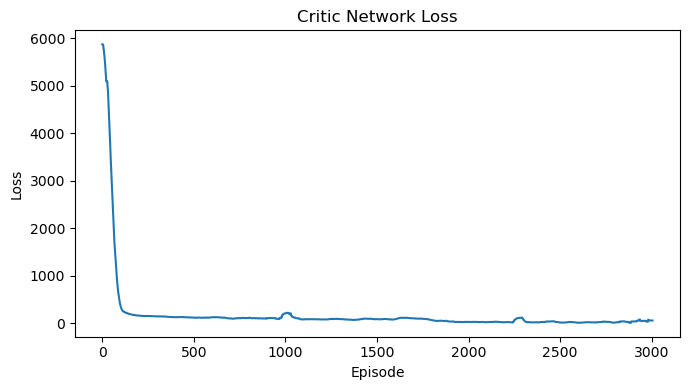

In [9]:
# TODO

## Cost-to-go

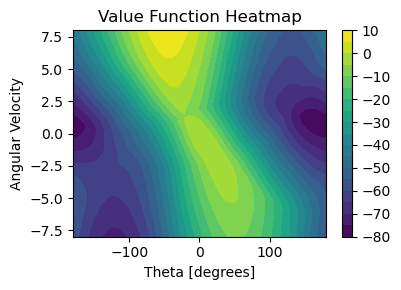

In [10]:
# TODO

## Policy map

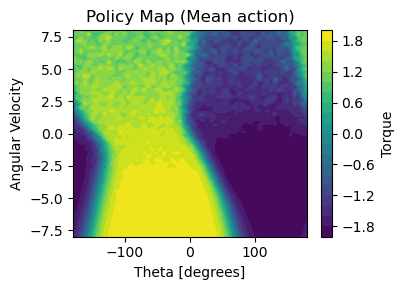

In [11]:
# TODO

## State histogram

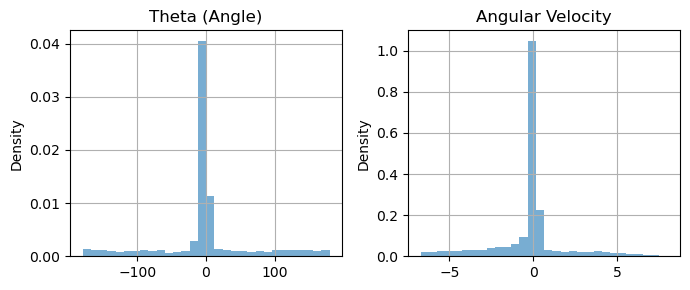

In [13]:
# TODO

## Render the learned policy

In [14]:
from IPython.display import Video, display
import cv2

def render_pendulum(policy_model):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    state, _ = env.reset()
    video_path = "A2C_render.mp4"
    frame_width, frame_height = env.render().shape[1], env.render().shape[0]
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(video_path, fourcc, 30, (frame_width, frame_height))
    for _ in range(num_timesteps):
        action = policy_model.select_action(state)
        state, reward, done, _, _ = env.step(action)
        frame = env.render()
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
        out.write(frame_bgr)
    out.release()
    env.close()
    display(Video(video_path))

render_pendulum(workers[0])